# Spectrum Generation

We use the data to generate spectra for the incidence of particles on the detector

In [1]:
#Include modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from accelerate import parallel, concat
from tqdm.notebook import tqdm
from scipy.stats import lognorm

%matplotlib widget

In [2]:
# Read the files

# Parameters
run                     = 'run6'
header                  = ['EventID','TrackID','Particle','InitialEnergy','DepositedEnergy','XPosition','YPosition','ZPosition','LocalTime','Volume']
runid                   = 'run0'

# Find the files
foldername  = f'./data/{run}'
filenames   = os.listdir(foldername)

print(f'Found {len(filenames)} data files in {foldername}')

def loadFile(filename):
    return pd.read_csv(os.path.join(foldername,filename),skiprows=14,names=header)

loadFiles = parallel(loadFile)

files = loadFiles([filename for filename in filenames if runid in filename])

Found 3000 data files in ./data/run6


  0%|          | 0/3000 [00:00<?, ?it/s]

In [3]:
# Function to extract the energy deposited per track
def getEnergy(data):
    return data.groupby(['EventID','TrackID','Particle'])['DepositedEnergy'].sum().reset_index()

getEnergies = concat(parallel(getEnergy))

# Put in one function
def getParticleEnergies(files):
    # Get the deposited energies
    energy = getEnergies(files)

    # Split into the energy per particle
    particleEnergies = {particle:energy.loc[energy.Particle.str.contains(particle)] for particle in energy.Particle.unique()}

    return particleEnergies

particleEnergies = getParticleEnergies(files)


  0%|          | 0/3000 [00:00<?, ?it/s]

In [4]:
# Smearing
# We will sample a lognormal distribution with a set standard deviation for each energy

# Retrieve the energies per file
getEnergyBatches = parallel(getEnergy)

# Parameters
STD = 0.005

# Define the semear function
def smear(energy):
    return np.random.normal(energy,scale=STD)

# Apply it to the dataframe
def smearEnergy(data):
    data.DepositedEnergy = data.DepositedEnergy.apply(smear)
    return data


# Parallelize
smearEnergies   = concat(parallel(smearEnergy))

def getParticleEnergiesSmeared(files):
    # Run it
    energyData      = getEnergyBatches(files)
    energySmeared   = smearEnergies(energyData)

    # Split into the energy per particle
    return {particle:energySmeared.loc[energySmeared.Particle.str.contains(particle)] for particle in energySmeared.Particle.unique()}

particleEnergiesSmeared = getParticleEnergiesSmeared(files)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Unique Particles found are:  ['gamma', 'e-', 'neutron']


/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


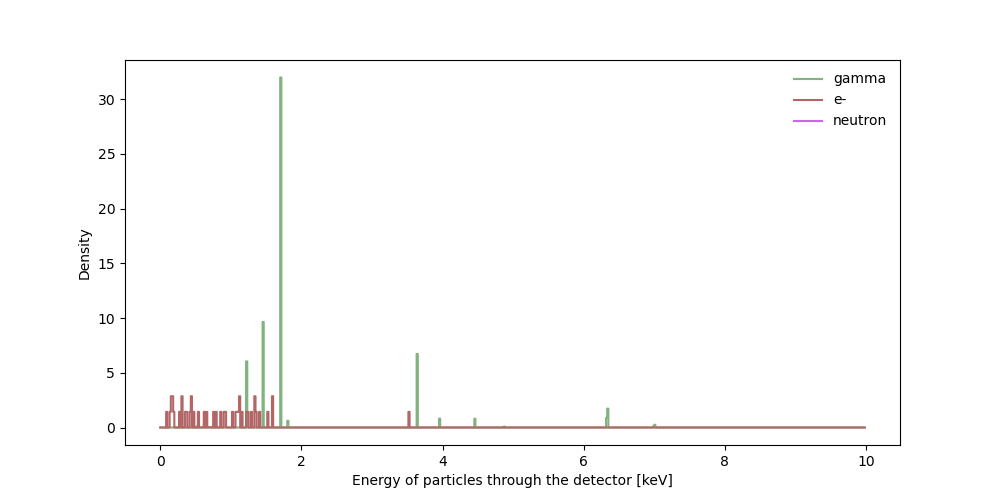

In [5]:
# Plot a histogram
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

NBINS       = 600
LIMS        = (0,10)
BINS        = np.linspace(*LIMS,NBINS+1)
stackedHist = np.array([np.histogram(particleEnergies[particle].DepositedEnergy,bins=BINS,density=True)[0] for particle in particleEnergies])
color       = np.round(np.random.rand(len(stackedHist),3),1)
[ax.step(BINS[:-1],hist,label=particle,color=c) for hist,particle,c in zip(stackedHist,particleEnergies,color)]

# ax.set_xlim(BINS[1],2)
# ax.set_ylim(0,np.max(,axis=0))
ax.set_ylabel('Density')
ax.set_xlabel('Energy of particles through the detector [keV]')
ax.legend(frameon=False)
# ax.set_yscale('log')
# ax.set_xscale('log')
fig.savefig('test.png')

print("Unique Particles found are: ",[key for key in particleEnergies])

In [6]:
MATERIAL = {
    'name' : 'Basalt',
    'peaks' : {
        'Fe\nKa' : 6.40,
        'Fe\nKb' : 7.06,
        'Ti\nKa' : 4.51,
        'Ti\nKb' : 4.93,
        'Si\nKa' : 1.74,
        'Al\nKa' : 1.49,
        'Mg\nKa' : 1.25,
        'O\nKa'  : 0.52,
    }
}

# Plot a histogram
def plotParticleHistogram(particleEnergies,PARTICLE = 'gamma',MATERIAL = MATERIAL,source='Cm244',MAX_PEAKS=15,NBINS=1000,LIMS=(0,10),SHOW_MATERIAL = True):
    fig = plt.figure(figsize=(10,5))
    ax  = fig.add_subplot(111)

    BINS        = np.linspace(*LIMS,NBINS+1)
    histogram   = np.histogram(particleEnergies[PARTICLE].DepositedEnergy,bins=BINS)[0]
    color       = np.round(np.random.rand(1,3),1)
    ax.step(BINS[:-1],histogram,label=PARTICLE,color=color[0])

    # Get the peaks
    if MAX_PEAKS>0:
        peak_index  = np.argsort(histogram)[-MAX_PEAKS:][::-1]
        peaks       = (BINS[peak_index+1] + BINS[peak_index])/2
        idx_unique  = np.sort(np.unique((peaks*10).astype('int'),return_index=True)[1])
        peak_index  = peak_index[idx_unique]
        peak_height = histogram[peak_index]
        peaks       = peaks[idx_unique] 

        ax.scatter(peaks,peak_height*1.5,c='k',marker = '1')
        for peak,height in zip(peaks,peak_height*1.55):
            ax.annotate("%.2f"%peak,(peak,height),ha='center', va='bottom')

    # Plot the Material peaks
    if SHOW_MATERIAL:
        for peak in MATERIAL['peaks']:
            ax.axvline(MATERIAL['peaks'][peak],ls='--',lw=0.5,c = 'grey')
            ax.annotate(f"{peak}",(MATERIAL['peaks'][peak],2*ax.get_ylim()[1]),ha='left', va='top',fontsize=10)

    ax.set_xlim(BINS[1],BINS[-1])
    ax.set_xlabel(f'Energy of {PARTICLE} particles through the detector [keV]')
    ax.set_ylabel('Density')
    ax.legend(frameon=False)
    ax.set_yscale('log')
    ax.set_ylim(None,ax.get_ylim()[1]*2)
    ax.set_title(f'{MATERIAL["name"]} spectrum by {source} source')

    fig.savefig(source+'.png')

    return fig,ax

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

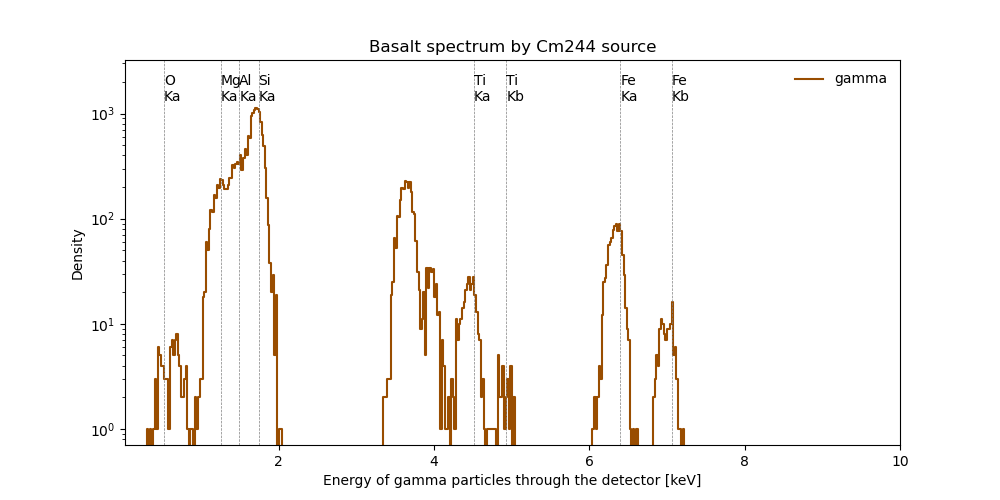

In [9]:
RUN_STRUCTURE = {
    'run0' : 'Cm244',
    # 'run1' : 'Fe55',
    # 'run2' : 'Cd109',
    # 'run3' : 'Co60',
    # 'run4' : 'Am241'
}

MATERIAL = {
    'name' : 'Basalt',
    'peaks' : {
        'FeKa' : 6.40,
        'FeKb' : 7.06,
        'TiKa' : 4.51,
        'TiKb' : 4.93,
        'SiKa' : 1.74,
        'AlKa' : 1.49,
        'MgKa' : 1.25,
        'OKa'  : 0.52,
    }
}

photon_fraction = {}
photon_mass     = {}
particle        = 'gamma'
STD             = 0.08

# For all the simulation runs
for run in tqdm(RUN_STRUCTURE):
    # Collect their output files
    files = loadFiles([filename for filename in filenames if run in filename])

    # Extract the energy for each particle
    particleEnergies = getParticleEnergiesSmeared(files)

    # photon_fraction[RUN_STRUCTURE[run]] = len(particleEnergies['gamma'])/len(energy)
    # photon_mass[RUN_STRUCTURE[run]]     = len(particleEnergies['gamma'])
    
    # Plot the spectrum
    if particle in particleEnergies: plotParticleHistogram(particleEnergies,
                                                           source=RUN_STRUCTURE[run],
                                                           PARTICLE=particle,
                                                           SHOW_MATERIAL=True,
                                                           LIMS=(0,10),
                                                           MAX_PEAKS=0,
                                                           NBINS=500)

In [8]:
print("The relative number of photons received on the detector per source is:") 
photon_rate = {source : photon_mass[source]/max(list(photon_mass.values())) for source in photon_mass}
for source in photon_rate:
    print("%5s: %.4f"%(source,photon_rate[source]))

The relative number of photons received on the detector per source is:
